In [5]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import pandas as pd
import sys
import os

# Linux下添加此代码(即添加临时模块搜索路径);当前项目路径为默认模块搜索路径(仅pycharm中)
sys.path.append(os.path.abspath(".." + os.sep + ".." + os.sep + ".."))

from text_classification.utils.train_evaluate import Trainer
from text_classification.models.TextLSTM import TextLSTM
from text_classification.data_ag_news.data.data_process_glove import DataProcess

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dp = DataProcess('../datasets/train.csv', '../datasets/test.csv', device, 512)
train_loader, test_loader = dp.get_dataLoader(141)
pre_vector = dp.get_pre_trained("glove.6B.50d.txt", '../../extra/glove_vector/')
print(pre_vector.shape)

torch.Size([95812, 50])


In [7]:
model = TextLSTM(num_class=4, vocab_size=pre_vector.shape[0], embedding_size=pre_vector.shape[1],
                 hidden_size=256, num_layers=2, dropout_ratio=0.3, bidirectional=True)
# 使用模型预训练词向量矩阵
model.embed.weight.data.copy_(pre_vector)
model.embed.weight.requires_grad = False  # 冻结网络层,使之不参与训练
model = model.to(device)

epochs = 20
lr = 0.01
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

In [8]:
def compute_metrics_f1(predict_all, y_true):
    """f1 score评估函数"""
    predict = predict_all.argmax(-1)
    label = y_true
    acc = f1_score(label, predict, average='micro')
    return {"f1": acc}


t_and_v = Trainer(model=model, optimizer=optimizer, criterion=criterion, epochs=epochs)

metric_result = t_and_v.train(train_loader=train_loader, valid_loader=test_loader,
                              compute_metrics=compute_metrics_f1, verbose=100)
metric_result_df = pd.DataFrame(metric_result)
metric_result_df.index.name = 'epoch'
metric_result_df

Train Epoch: 0  [0    /120000 (0  %)]	Loss: 1.386306	f1: 0.244141
Train Epoch: 0  [51200/120000 (43 %)]	Loss: 1.382028	f1: 0.330078
Train Epoch: 0  [102400/120000 (85 %)]	Loss: 1.378615	f1: 0.431641
Train Epoch: 0  [120000/120000 (100%)]	Loss: 1.378678	f1: 0.484375
----------------------------------------------------------------------------------------------------
Train Epoch: 1  [0    /120000 (0  %)]	Loss: 1.377769	f1: 0.419922
Train Epoch: 1  [51200/120000 (43 %)]	Loss: 1.372202	f1: 0.542969
Train Epoch: 1  [102400/120000 (85 %)]	Loss: 1.369114	f1: 0.582031
Train Epoch: 1  [120000/120000 (100%)]	Loss: 1.365129	f1: 0.640625
----------------------------------------------------------------------------------------------------
Train Epoch: 2  [0    /120000 (0  %)]	Loss: 1.368109	f1: 0.582031
Train Epoch: 2  [51200/120000 (43 %)]	Loss: 1.361467	f1: 0.648438
Train Epoch: 2  [102400/120000 (85 %)]	Loss: 1.358020	f1: 0.656250
Train Epoch: 2  [120000/120000 (100%)]	Loss: 1.361839	f1: 0.583333


,Training loss,Training f1,Validation loss,Validation f1
epoch,,,,
0,1.377616,0.597442,1.377654,0.591316
1,1.367578,0.701958,1.367741,0.693289
2,1.354647,0.716675,1.354971,0.707763
3,1.335955,0.728150,1.336519,0.723026
4,1.306333,0.741158,1.307295,0.736053
5,1.254591,0.748317,1.256293,0.743947
6,1.154206,0.760767,1.157451,0.755921
7,0.952831,0.776050,0.959166,0.774342
8,0.703079,0.792992,0.710803,0.791053


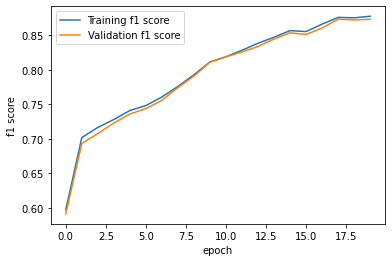

In [9]:
plt.plot(metric_result['Training f1'], label='Training f1 score')
plt.plot(metric_result['Validation f1'], label='Validation f1 score')
plt.ylabel('f1 score')
plt.xlabel('epoch')
plt.legend()
plt.show()